# Introduction

This notebook presents **ResNet50** architecutre build **from scratch** and applied to [Oxford VGG Flowers 17](http://www.robots.ox.ac.uk/~vgg/data/flowers/) dataset.

**Contents**

* [VGG Flowers 17 Dataset](#VGG-Flowers-17-Dataset)
* [ResNet-50 From Scratch](#ResNet-50-From-Scratch)


**References**

* [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) (2015) by Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
with tf.Session(config=config):
    pass  # init sessin with allow_growth

# VGG Flowers 17 Dataset

In [3]:
dataset_location = '../Udacity_DL_Nanodegree//'

In [4]:
datafile = os.path.join(dataset_location, '17flowers.npz')
if not os.path.isfile(datafile):
    print('Run StanfordDogs.ipynb notebook first!')
    raise

In [5]:
npzfile = np.load(datafile)
train_images_raw = npzfile['train_images']
train_labels_raw = npzfile['train_labels']
valid_images_raw = npzfile['valid_images']
valid_labels_raw = npzfile['valid_labels']

In [6]:
train_images = tf.keras.applications.resnet50.preprocess_input(train_images_raw.astype(np.float32))
valid_images = tf.keras.applications.resnet50.preprocess_input(valid_images_raw.astype(np.float32))
print('train_images.shape:', train_images.shape)
print('valid_images.shape:', valid_images.shape)
print('valid_images:\n', valid_images[0,:,:,0].round())  # first image, red channel

train_images.shape: (1190, 224, 224, 3)
valid_images.shape: (170, 224, 224, 3)
valid_images:
 [[-102. -104. -103. ... -104. -102. -104.]
 [-101. -103. -103. ... -104.  -97.  -93.]
 [-102. -104. -103. ...  -85.  -73.  -55.]
 ...
 [ -57.  -58.  -60. ...  -79.  -82.  -83.]
 [ -54.  -58.  -61. ...  -83.  -79.  -76.]
 [ -63.  -68.  -70. ...  -85.  -82.  -79.]]


In [7]:
train_labels = tf.keras.utils.to_categorical(train_labels_raw)
valid_labels = tf.keras.utils.to_categorical(valid_labels_raw)
print('train_labels.shape:', train_labels.shape)
print('valid_labels.shape:', valid_labels.shape)
print('valid_labels:\n', valid_labels)

train_labels.shape: (1190, 17)
valid_labels.shape: (170, 17)
valid_labels:
 [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


# ResNet-50 From Scratch

In [8]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Add
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense

In [9]:
def residual_block(X_start, filters, name, reduce=False, res_conv2d=False):
    """
    Residual building block used by ResNet-50
    """
    nb_filters_1, nb_filters_2, nb_filters_3 = filters
    strides_1 = [2,2] if reduce else [1,1]
        
    X = Conv2D(filters=nb_filters_1, kernel_size=[1,1], strides=strides_1, padding='same', name=name)(X_start)
    X = BatchNormalization()(X)      # default axis-1 is ok
    X = Activation('relu')(X)
    
    X = Conv2D(filters=nb_filters_2, kernel_size=[3,3], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    X = Activation('relu')(X)
    
    X = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=[1,1], padding='same')(X)
    X = BatchNormalization()(X)
    
    if res_conv2d:
        X_res = Conv2D(filters=nb_filters_3, kernel_size=[1,1], strides=strides_1, padding='same')(X_start)
        X_res = BatchNormalization()(X_res)
    else:
        X_res = X_start
        
    X = Add()([X, X_res])
    X = Activation('relu')(X)
    return X

In [12]:
def resnet50(input_shape, nb_classes):
    assert len(input_shape) == 3
    
    X_input = Input(shape=input_shape)

    # conv1
    X = Conv2D(filters=64, kernel_size=[7,7], strides=[2,2], padding='same', name='conv1')(X_input)
    X = BatchNormalization(name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D([3,3], strides=[2,2])(X)

    # conv2_x
    X = residual_block(X, filters=[64, 64, 256], name='conv2_a', reduce=False, res_conv2d=True)
    X = residual_block(X, filters=[64, 64, 256], name='conv2_b')
    X = residual_block(X, filters=[64, 64, 256], name='conv2_c')

    # conv3_x
    X = residual_block(X, filters=[128, 128, 512], name='conv3_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[128, 128, 512], name='conv3_b')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_c')
    X = residual_block(X, filters=[128, 128, 512], name='conv3_d')

    # conv4_x
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_b')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_c')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_d')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_e')
    X = residual_block(X, filters=[256, 256, 1024], name='conv4_f')

    # conv5_x
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_a', reduce=True, res_conv2d=True)
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_b')
    X = residual_block(X, filters=[512, 512, 2048], name='conv5_c')

    X = GlobalAveragePooling2D(name='avg_pool')(X)
    X = Flatten()(X)
    X = Dense(units=nb_classes, activation='softmax')(X)
    
    model = tf.keras.models.Model(inputs=X_input, outputs=X)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
model = resnet50(input_shape=[224, 224, 3], nb_classes=17)
# model.summary()  # this should be identical to tf.keras.applications.ResNet50()

In [14]:
hist = model.fit(x=train_images, y=train_labels, batch_size=34, epochs=30,
                 validation_data=(valid_images, valid_labels), verbose=2)

Train on 1190 samples, validate on 170 samples
Epoch 1/30
 - 29s - loss: 2.8798 - acc: 0.1378 - val_loss: 2.8288 - val_acc: 0.0529
Epoch 2/30
 - 14s - loss: 2.1434 - acc: 0.2840 - val_loss: 3.0685 - val_acc: 0.0588
Epoch 3/30
 - 14s - loss: 1.7837 - acc: 0.3882 - val_loss: 3.4104 - val_acc: 0.0824
Epoch 4/30
 - 14s - loss: 1.5180 - acc: 0.4782 - val_loss: 3.7846 - val_acc: 0.0588
Epoch 5/30
 - 14s - loss: 1.3824 - acc: 0.5336 - val_loss: 3.9308 - val_acc: 0.1353
Epoch 6/30
 - 14s - loss: 1.1888 - acc: 0.5874 - val_loss: 3.7808 - val_acc: 0.1706
Epoch 7/30
 - 14s - loss: 1.0881 - acc: 0.6395 - val_loss: 3.6273 - val_acc: 0.2176
Epoch 8/30
 - 14s - loss: 0.9233 - acc: 0.6882 - val_loss: 4.5002 - val_acc: 0.1294
Epoch 9/30
 - 14s - loss: 0.8287 - acc: 0.7445 - val_loss: 3.1837 - val_acc: 0.2765
Epoch 10/30
 - 14s - loss: 0.7363 - acc: 0.7655 - val_loss: 2.5050 - val_acc: 0.3000
Epoch 11/30
 - 14s - loss: 0.6023 - acc: 0.7891 - val_loss: 2.5601 - val_acc: 0.3647
Epoch 12/30
 - 14s - loss: 

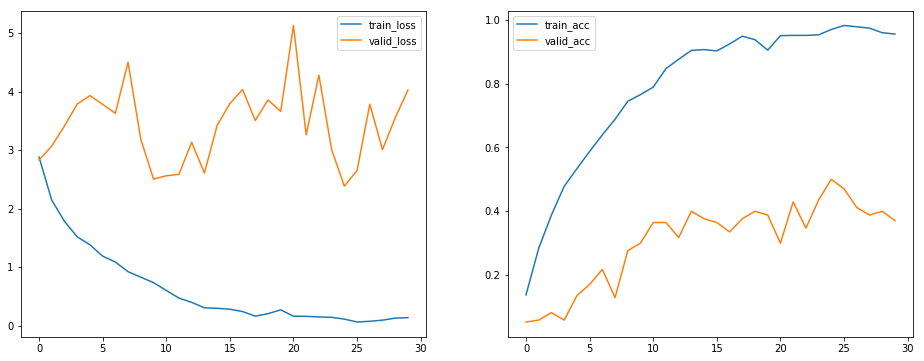

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16,6])
ax1.plot(hist.history['loss'], label='train_loss')
ax1.plot(hist.history['val_loss'], label='valid_loss')
ax1.legend()
ax2.plot(hist.history['acc'], label='train_acc')
ax2.plot(hist.history['val_acc'], label='valid_acc')
ax2.legend();